<a href="https://colab.research.google.com/github/NRC-Lund/radiation-WM/blob/main/WM_analysis_Behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

from matplotlib import style, offsetbox
import matplotlib.cm as cm
style.use('ggplot') or plt.style.use('ggplot')

import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import mannwhitneyu
pip install scikit-posthocs


import sklearn.feature_selection as featsel
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from ipywidgets import interact, widgets

import os

import time

import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 2.5 MB/s eta 0:00:00


In [ ]:
#define seaborn background colors
#sns.despine();
sns.set_style("whitegrid")
plt.rcParams['axes.edgecolor'] = '#000000'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
#plt.rcParams['ytick.labelleft'] = True

### Loading Data

In [ ]:
Colab_flag = True

In [ ]:
if Colab_flag:
  from google.colab import drive
  drive.mount('/content/drive')
  homeFolder = '/content/drive/MyDrive/Colab Notebooks/WM/'
else:
  homeFolder = '/Users/sbk/Documents/Lab/WM/'

picFolder = homeFolder + 'Pics/'

Mounted at /content/drive


#Behavior

In [ ]:
# Statistical evaluation
def getpval(df, var):
    # Hypothesis test: compare the means of two treatments
    treatment_a = df[(df['Treatment'] == 'Control') | (df['Treatment'] == 'CTRL')][var]
    treatment_b = df[df['Treatment'] == 'WB'][var]
    t_statistic, p_value = stats.mannwhitneyu(treatment_a, treatment_b, nan_policy='omit')
    return t_statistic, p_value


In [ ]:
def bootstrap_test(distribution1, distribution2):
    num_samples = 10000
    confidence_level = 0.95

    # Compute the observed statistic
    observed_statistic = np.mean(distribution1) - np.mean(distribution2)

    # Combine the two distributions
    combined_data = np.concatenate((distribution1, distribution2))

    # Initialize an array to store the bootstrap statistics
    bootstrap_statistics = np.zeros(num_samples)

    # Perform bootstrapping
    for i in range(num_samples):
        # Generate a bootstrap sample
        bootstrap_sample = np.random.choice(combined_data, size=len(combined_data), replace=True)

        # Compute the statistic for the bootstrap sample
        bootstrap_statistic = np.mean(bootstrap_sample[:len(distribution1)]) - np.mean(bootstrap_sample[len(distribution1):])

        # Store the bootstrap statistic
        bootstrap_statistics[i] = bootstrap_statistic

    # Compute the p-value
    p_value = (np.abs(bootstrap_statistics) >= np.abs(observed_statistic)).mean()

    # Compute the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_bound = np.percentile(bootstrap_statistics, alpha * 100)
    upper_bound = np.percentile(bootstrap_statistics, (1 - alpha) * 100)

    # Return the observed statistic, p-value, and confidence interval
    return observed_statistic, p_value, (lower_bound, upper_bound)

#observed_statistic, p_value, confidence_interval = bootstrap_test(distribution1, distribution2)

#print("Observed statistic:", observed_statistic)
#print("P-value:", p_value)
#print("Confidence interval:", confidence_interval)


In [ ]:
def bootstrap_test(distribution1, distribution2):
    num_samples = 10000
    confidence_level = 0.95

    # Calculate the sample sizes
    N1 = len(distribution1)
    N2 = len(distribution2)

    # Test for normality using the Shapiro-Wilk test
    _, p_normal1 = stats.shapiro(distribution1)
    _, p_normal2 = stats.shapiro(distribution2)

    if p_normal1 > 0.05 and p_normal2 > 0.05:
        # Both distributions are normally distributed, use Welch's t-test
        test_type = "t-test (Welch)"
        t_stat, p_value_parametric = stats.ttest_ind(distribution1, distribution2, equal_var=False, nan_policy = 'omit')

        # Calculate degrees of freedom for Welch's t-test
        df = (np.var(distribution1)/N1 + np.var(distribution2)/N2)**2 / (
            (np.var(distribution1)/N1)**2 / (N1-1) + (np.var(distribution2)/N2)**2 / (N2-1))

        # Calculate mean and standard error
        mean1 = np.mean(distribution1)
        mean2 = np.mean(distribution2)
        se1 = np.std(distribution1, ddof=1) / np.sqrt(N1)
        se2 = np.std(distribution2, ddof=1) / np.sqrt(N2)

        # Use the t-statistic as the test statistic
        test_stat = t_stat

        central_tendency_measure1 = f"Mean: {mean1:.4f} ± SE: {se1:.4f}"
        central_tendency_measure2 = f"Mean: {mean2:.4f} ± SE: {se2:.4f}"
    else:
        # At least one distribution is not normally distributed, use Mann-Whitney U test
        test_type = "Mann-Whitney U test"
        u_stat, p_value_parametric = stats.mannwhitneyu(distribution1, distribution2, alternative='two-sided', nan_policy = 'omit')

        # Mann-Whitney U test does not use degrees of freedom
        df = None

        # Calculate median and standard error
        median1 = np.median(distribution1)
        median2 = np.median(distribution2)
        se1 = np.std(distribution1, ddof=1) / np.sqrt(N1)
        se2 = np.std(distribution2, ddof=1) / np.sqrt(N2)

        # Use the U-statistic as the test statistic
        test_stat = u_stat

        central_tendency_measure1 = f"Median: {median1:.4f} ± SE: {se1:.4f}"
        central_tendency_measure2 = f"Median: {median2:.4f} ± SE: {se2:.4f}"

    # Combine the two distributions for bootstrapping
    combined_data = np.concatenate((distribution1, distribution2))

    # Initialize an array to store the bootstrap statistics
    bootstrap_statistics = np.zeros(num_samples)

    # Compute the observed statistic for bootstrapping
    observed_statistic = np.mean(distribution1) - np.mean(distribution2)

    # Perform bootstrapping
    for i in range(num_samples):
        # Generate a bootstrap sample
        bootstrap_sample = np.random.choice(combined_data, size=len(combined_data), replace=True)

        # Compute the statistic for the bootstrap sample
        bootstrap_statistic = np.mean(bootstrap_sample[:len(distribution1)]) - np.mean(bootstrap_sample[len(distribution1):])

        # Store the bootstrap statistic
        bootstrap_statistics[i] = bootstrap_statistic

    # Compute the p-value for the bootstrap test
    p_value_bootstrap = (np.abs(bootstrap_statistics) >= np.abs(observed_statistic)).mean()

    # Compute the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_bound = np.percentile(bootstrap_statistics, alpha * 100)
    upper_bound = np.percentile(bootstrap_statistics, (1 - alpha) * 100)

    # Create a dictionary of results
    results = {
        'Observed Statistic': observed_statistic,
        'Bootstrap P-Value': p_value_bootstrap,
        'Confidence Interval (Lower)': lower_bound,
        'Confidence Interval (Upper)': upper_bound,
        'Test Type': test_type,
        'Test Statistic': test_stat,
        'Degrees of Freedom': df,
        'Parametric P-Value': p_value_parametric,
        'Sample Size Group 1 (N1)': N1,
        'Sample Size Group 2 (N2)': N2,
        'Group 1 Central Tendency': central_tendency_measure1,
        'Group 2 Central Tendency': central_tendency_measure2
    }

    # Convert the dictionary to a DataFrame for a tabular display
    df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

    # Return the table
    return df_results

# Example usage:
# distribution1 = np.random.randn(50)
# distribution2 = np.random.randn(50) + 0.5
# result_table = bootstrap_test(distribution1, distribution2)
# Print the result as a table
# print(result_table)


In [ ]:
def bootstrap_test(distribution1, distribution2):
    num_samples = 10000
    confidence_level = 0.95

    # Calculate the sample sizes
    N1 = len(distribution1)
    N2 = len(distribution2)

    # Test for normality using the Shapiro-Wilk test
    _, p_normal1 = stats.shapiro(distribution1)
    _, p_normal2 = stats.shapiro(distribution2)


    # At least one distribution is not normally distributed, use Mann-Whitney U test
    test_type = "Mann-Whitney U test"
    u_stat, p_value_parametric = stats.mannwhitneyu(distribution1, distribution2, alternative='two-sided', nan_policy = 'omit')

    # Mann-Whitney U test does not use degrees of freedom
    df = None

    # Calculate median and standard error
    median1 = np.mean(distribution1)
    median2 = np.mean(distribution2)
    se1 = np.std(distribution1, ddof=1) / np.sqrt(N1)
    se2 = np.std(distribution2, ddof=1) / np.sqrt(N2)

    # Use the U-statistic as the test statistic
    test_stat = u_stat

    central_tendency_measure1 = f"Mean: {median1:.4f} ± SE: {se1:.4f}"
    central_tendency_measure2 = f"Mean: {median2:.4f} ± SE: {se2:.4f}"

    # Combine the two distributions for bootstrapping
    combined_data = np.concatenate((distribution1, distribution2))

    # Initialize an array to store the bootstrap statistics
    bootstrap_statistics = np.zeros(num_samples)

    # Compute the observed statistic for bootstrapping
    observed_statistic = np.mean(distribution1) - np.mean(distribution2)

    # Perform bootstrapping
    for i in range(num_samples):
        # Generate a bootstrap sample
        bootstrap_sample = np.random.choice(combined_data, size=len(combined_data), replace=True)

        # Compute the statistic for the bootstrap sample
        bootstrap_statistic = np.mean(bootstrap_sample[:len(distribution1)]) - np.mean(bootstrap_sample[len(distribution1):])

        # Store the bootstrap statistic
        bootstrap_statistics[i] = bootstrap_statistic

    # Compute the p-value for the bootstrap test
    p_value_bootstrap = (np.abs(bootstrap_statistics) >= np.abs(observed_statistic)).mean()

    # Compute the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_bound = np.percentile(bootstrap_statistics, alpha * 100)
    upper_bound = np.percentile(bootstrap_statistics, (1 - alpha) * 100)

    # Create a dictionary of results
    results = {
        'Observed Statistic': observed_statistic,
        'Bootstrap P-Value': p_value_bootstrap,
        'Confidence Interval': [lower_bound, upper_bound],
        'Test Type': test_type,
        'Test Statistic': test_stat,
        'Degrees of Freedom': df,
        'Parametric P-Value': p_value_parametric,
        'Sample Size Group 1 (N1)': N1,
        'Sample Size Group 2 (N2)': N2,
        'Group 1 Central Tendency': central_tendency_measure1,
        'Group 2 Central Tendency': central_tendency_measure2
    }

    # Convert the dictionary to a DataFrame for a tabular display
    df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

    # Return the table
    return df_results

# Example usage:
# distribution1 = np.random.randn(50)
# distribution2 = np.random.randn(50) + 0.5
# result_table = bootstrap_test(distribution1, distribution2)
# Print the result as a table
# print(result_table)


In [ ]:
def remove_outliers(df, column_name, multiplier=1.5):
    """
    Remove outliers from a specific column in a DataFrame using the IQR method.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column_name (str): The name of the column from which outliers will be removed.
    - multiplier (float): The multiplier to determine the outlier threshold (default is 1.5).

    Returns:
    - pd.DataFrame: DataFrame without outliers in the specified column.
    """

    # Select the specified column
    column_data = df[column_name]

    # Calculate the IQR (Interquartile Range)
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Filter out rows with values outside the bounds
    df_filtered = df[(column_data >= lower_bound) & (column_data <= upper_bound)]

    return df_filtered


In [ ]:
def ttxpalette(bTtx):
  TtxNames = ['Control', 'CTRL', 'CS', 'HF', 'WB'];
  #colors2 = ['#3f51b5', '#ffa700', '#34a853', '#ea4335'];
  colors2 = ['#3f51b5', '#3f51b5', '#ffa700', '#ffa700', '#ffa700'];

  # Create a dictionary to map TtxNames to colors
  color_dict = {ttx: color for ttx, color in zip(TtxNames, colors2)}

  # Create a list of colors corresponding to TtxNames
  bpalette = [color_dict[ttx] for ttx in bTtx]

  # Set the seaborn palette
  sns.set_palette(bpalette)

  return bpalette

def epochpalette(bEpoch = ['Start', 'Cue', 'Running', 'Reward', 'Timeout']):
  EpochNames = ['Start', 'Cue', 'Running', 'Reward', 'Timeout', 'TimeOut'];
  colors2 = ['#d11141', '#00b159', '#00aedb', '#f37735', '#767676', '#767676'];

  # Create a dictionary to map TtxNames to colors
  color_dict = {ex: color for ex, color in zip(EpochNames, colors2)}

  # Create a list of colors corresponding to TtxNames
  bpalette = [color_dict[ex] for ex in bEpoch]

  # Set the seaborn palette
  sns.set_palette(bpalette)

  return bpalette

def strpalette(bStructure = ['plPFC', 'ilPFC', 'OFC', 'M2', 'DLS', 'NAcCore', 'PPC', 'dHipp', 'vHipp', 'MDT']):
  StrNames = ['plPFC', 'ilPFC', 'OFC', 'M2', 'DLS', 'NAcCore', 'PPC', 'dHipp', 'vHipp', 'MDT']
  colors2 = ['#ff1000', '#ff5000', '#ff8000', '#ffaf00', '#52b855', '#245923', '#3f20c0', '#3f63c0', '#3fa7c0', '#800eec'];

  # Create a dictionary to map TtxNames to colors
  color_dict = {ex: color for ex, color in zip(StrNames, colors2)}

  # Create a list of colors corresponding to TtxNames
  bpalette = [color_dict[ex] for ex in bStructure]

  # Set the seaborn palette
  sns.set_palette(bpalette)

  return bpalette


In [ ]:
TtxNames = ['Control', 'CS', 'HF', 'WB'];

path = homeFolder + 'Beh_OF.csv'
OF= pd.read_csv(path)
OF.Treatment[OF.Treatment == 'CTRL'] = 'Control'
OF.Treatment[OF.Treatment == 'HIPP'] = 'HF'
OF.Treatment[OF.Treatment == 'PFC'] = 'CS'
OF.head(3)

,Animal,Rec,Occ,Coverage,Dist,Corners,Treatment
0,R3,20170714_OF_A,164.2,1.589023,46.656609,341.96,Control
1,R5,20170714_OF_B,142.0,2.039209,55.325031,278.56,Control
2,R4,20170714_OF_C,102.0,1.762482,62.172243,282.32,Control


In [ ]:
path = homeFolder + 'Beh_NOR.csv'
NOR= pd.read_csv(path)
NOR.Treatment[NOR.Treatment == 'CTRL'] = 'Control'
NOR.Treatment[NOR.Treatment == 'HIPP'] = 'HF'
NOR.Treatment[NOR.Treatment == 'PFC'] = 'CS'

NOR.head(3)

,Animal,Rec,Occ,Coverage,Dist,Corners,Treatment,Novel,nVis_novel,nVis_fam,tVis_novel,tVis_fam,DI
0,R5,20170715_NOR_B,90.96,0.027411,79.863158,127.56,Control,0,2,2,1.56,4.28,-0.465753
1,R1,20170715_NOR_E,234.36,0.024092,67.067193,99.00,Control,0,4,4,12.40,7.16,0.267894
2,R24,20171018_NOR_D,37.36,0.024658,59.797928,119.08,HF,1,4,4,13.52,6.40,0.357430


In [ ]:
path = homeFolder + 'Beh_OLR.csv'
OLR= pd.read_csv(path)
OLR.Treatment[OLR.Treatment == 'CTRL'] = 'Control'
OLR.Treatment[OLR.Treatment == 'HIPP'] = 'HF'
OLR.Treatment[OLR.Treatment == 'PFC'] = 'CS'
OLR.head(3)

,Animal,Rec,Occ,Coverage,Dist,Corners,Treatment,Novel,nVis_novel,nVis_fam,tVis_novel,tVis_fam,DI
0,R5,20170721_OLR_A,33.24,0.017733,81.035036,140.04,Control,1,4,6,7.60,12.44,-0.241517
1,R3,20170721_OLR_B,29.16,0.012835,94.706584,151.92,Control,0,3,1,8.12,0.52,0.879630
2,R4,20170721_OLR_C,67.48,0.029317,87.167509,119.32,Control,1,4,5,2.56,3.88,-0.204969


OF test: 
                                                            Value
Observed Statistic                                       3.035585
Bootstrap P-Value                                          0.4088
Confidence Interval       [-7.722238537354634, 7.049497635745419]
Test Type                                     Mann-Whitney U test
Test Statistic                                              354.0
Degrees of Freedom                                           None
Parametric P-Value                                       0.467622
Sample Size Group 1 (N1)                                       37
Sample Size Group 2 (N2)                                       17
Group 1 Central Tendency               Mean: 40.7953 ± SE: 2.3620
Group 2 Central Tendency               Mean: 37.7597 ± SE: 2.1158

NOR test: 
                                                                Value
Observed Statistic                                           0.149843
Bootstrap P-Value                             

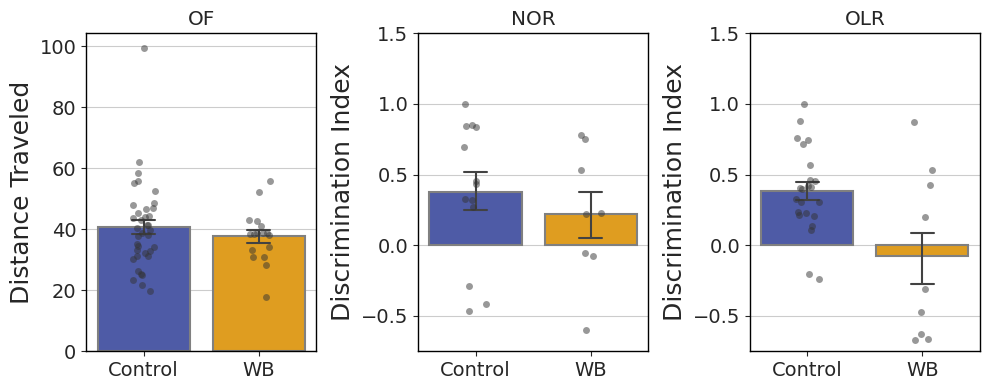

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (10,4))

bTtx = ['Control', 'WB']
hax = ax[0]
var = 'Dist'
sns.stripplot(data = OF[np.in1d(OF.Treatment, bTtx)], x = 'Treatment', y = var, ax = hax, order = bTtx, color = '.2', edgecolor = 'k', alpha = 0.5)
sns.barplot(data = OF[np.in1d(OF.Treatment, bTtx)], x = 'Treatment', y = var, ax = hax, capsize=.2, errwidth = 1.5, linewidth=1.5, edgecolor=".5", palette = ttxpalette(bTtx), ci=68)
#tstat, p_value = getpval(OF[np.in1d(OF.Treatment, ['Control', 'WB'])], 'Occ');
#observed_statistic, p_value, confidence_interval = bootstrap_test(OF[np.in1d(OF.Treatment, ['Control'])][var], OF[np.in1d(OF.Treatment, ['WB'])][var])
a = bootstrap_test(OF[np.in1d(OF.Treatment, ['Control'])][var], OF[np.in1d(OF.Treatment, ['WB'])][var])
print(f'OF test: \n{a}')
hax.set_ylabel('Distance Traveled');
hax.set_title('OF');
hax.set_xlabel(None)

hax = ax[1]
sns.stripplot(data = NOR[np.in1d(NOR.Treatment, bTtx)], x = 'Treatment', y = 'DI', ax = hax, order = bTtx, color = '.2', edgecolor = 'k', alpha = 0.5)
sns.barplot(data = NOR[np.in1d(NOR.Treatment, bTtx)], x = 'Treatment', y = 'DI', ax = hax, capsize=.2, errwidth = 1.5, linewidth=1.5, edgecolor=".5", palette = ttxpalette(bTtx), ci=68)
#observed_statistic, p_value, confidence_interval = bootstrap_test(NOR[np.in1d(NOR.Treatment, ['Control'])].DI, NOR[np.in1d(NOR.Treatment, ['WB'])].DI)
a = bootstrap_test(NOR[np.in1d(NOR.Treatment, ['Control'])].DI, NOR[np.in1d(NOR.Treatment, ['WB'])].DI)
#stat, p_value = mannwhitneyu(NOR[np.in1d(NOR.Treatment, ['Control'])].DI, NOR[np.in1d(NOR.Treatment, ['WB'])].DI, alternative='two-sided')

print(f'\nNOR test: \n{a}')
hax.set_ylabel('Discrimination Index');
hax.set_title('NOR');
hax.set_xlabel(None)
hax.set_ylim([-0.75, 1.5])

hax = ax[2]
sns.stripplot(data = OLR[np.in1d(OLR.Treatment, bTtx)], x = 'Treatment', y = 'DI', ax = hax, order = bTtx, color = '.2', edgecolor = 'k', alpha = 0.5)
sns.barplot(data = OLR[np.in1d(OLR.Treatment, bTtx)], x = 'Treatment', y = 'DI', ax = hax, capsize=.2, errwidth = 1.5, linewidth=1.5, edgecolor=".5", palette = ttxpalette(bTtx), ci=68)
#observed_statistic, p_value, confidence_interval = bootstrap_test(OLR[np.in1d(OLR.Treatment, ['Control'])].DI, OLR[np.in1d(OLR.Treatment, ['WB'])].DI)
a = bootstrap_test(OLR[np.in1d(OLR.Treatment, ['Control'])].DI, OLR[np.in1d(OLR.Treatment, ['WB'])].DI)
#stat, p_value = mannwhitneyu(OLR[np.in1d(OLR.Treatment, ['Control'])].DI, OLR[np.in1d(OLR.Treatment, ['WB'])].DI, alternative='two-sided')

print(f'\nOLR test: \n{a}')
hax.set_ylabel('Discrimination Index');
hax.set_title('OLR');
hax.set_xlabel(None)
hax.set_ylim([-0.75, 1.5])

fname = f'Beh1.png'
plt.tight_layout()
#plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None,bbox_inches='tight', pad_inches=0.1,facecolor='white', edgecolor='auto',backend=None)
plt.show()


In [ ]:
import numpy as np
from scipy.stats import wilcoxon, iqr

# Example sample data
for ttx in ['Control', 'WB']:

    # Sample data for each treatment group
    sample = np.array(NOR.DI[NOR.Treatment == ttx])

    # Single number to compare against
    single_number = 0

    # Calculate the differences from the single number
    differences = sample - single_number

    # Perform the Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(differences)

    # Calculate the sample size, median, and interquartile range (IQR)
    sample_size = len(sample)
    sample_median = np.median(sample)
    sample_iqr = iqr(sample)

    # Print the results
    print(f"Treatment: {ttx}")
    print(f"Wilcoxon statistic (W): {statistic}")
    print(f"P-value: {p_value}")
    print(f"Sample size (n): {sample_size}")
    print(f"Median: {sample_median}")
    print(f"IQR: {sample_iqr}")

    # Interpret the result
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"The median of the sample is significantly different from {single_number}.")
    else:
        print(f"The median of the sample is not significantly different from {single_number}.")

    print("\n")


Treatment: Control
Wilcoxon statistic (W): 15.0
P-value: 0.03271484375
Sample size (n): 13
Median: 0.432692307692308
IQR: 0.5724257007457481
The median of the sample is significantly different from 0.


Treatment: WB
Wilcoxon statistic (W): 9.0
P-value: 0.25
Sample size (n): 8
Median: 0.22677045908183652
IQR: 0.647446993823187
The median of the sample is not significantly different from 0.




In [ ]:
import numpy as np
from scipy.stats import wilcoxon, iqr

# Example sample data
for ttx in ['Control', 'WB']:

    # Sample data for each treatment group
    sample = np.array(OLR.DI[OLR.Treatment == ttx])

    # Single number to compare against
    single_number = 0

    # Calculate the differences from the single number
    differences = sample - single_number

    # Perform the Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(differences)

    # Calculate the sample size, median, and interquartile range (IQR)
    sample_size = len(sample)
    sample_median = np.median(sample)
    sample_iqr = iqr(sample)

    # Print the results
    print(f"Treatment: {ttx}")
    print(f"Wilcoxon statistic (W): {statistic:.2f}")
    print(f"P-value: {p_value:.2f}")
    print(f"Sample size (n): {sample_size}")
    print(f"Median: {sample_median}")
    print(f"IQR: {sample_iqr}")

    # Interpret the result
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"The median of the sample is significantly different from {single_number}.")
    else:
        print(f"The median of the sample is not significantly different from {single_number}.")

    print("\n")


Treatment: Control
Wilcoxon statistic (W): 11.00
P-value: 0.00
Sample size (n): 23
Median: 0.4
IQR: 0.2938490124455835
The median of the sample is significantly different from 0.


Treatment: WB
Wilcoxon statistic (W): 18.00
P-value: 0.65
Sample size (n): 9
Median: -0.30938123752495
IQR: 1.0493535222548531
The median of the sample is not significantly different from 0.




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import pairwise_tukey

def run_anova_and_posthoc(data, var, factors):
    # Two-way ANOVA without interaction term
    #formula = f'{var} ~ {"*".join(factors)}'
    formula = f'{var} ~ {factors[0]} + {factors[1]} + {factors[0]}*{factors[1]}'
    model = ols(formula, data=data).fit()
    anova_table = anova_lm(model)

    data_encoded = data.copy()
    for factor in factors:
      data_encoded[factor] = data_encoded[factor].astype('category').cat.codes

    # Post-hoc pairwise comparisons with Tukey's test
    posthoc_results = {}
    for treatment in data['Treatment'].unique():
        subset = data[data['Treatment'] == treatment]
        posthoc = pairwise_tukey(data=subset, dv=var, between='Object')
        posthoc_results[treatment] = posthoc

    # Print post-hoc results
    # Print ANOVA table
    print("ANOVA Table:")
    print(anova_table)
    for treatment, posthoc in posthoc_results.items():
        print(f"\nPost-hoc Pairwise Comparisons for Treatment {treatment}:")
        print(posthoc)

    return anova_table, posthoc_results

In [ ]:
OF.head()

,Animal,Rec,Occ,Coverage,Dist,Corners,Treatment
0,R3,20170714_OF_A,164.20,1.589023,46.656609,341.96,Control
1,R5,20170714_OF_B,142.00,2.039209,55.325031,278.56,Control
2,R4,20170714_OF_C,102.00,1.762482,62.172243,282.32,Control
3,R1,20170714_OF_E,178.88,2.029748,47.029862,334.28,Control
4,R13,20170717_OF_K,318.24,2.227510,37.821261,80.88,Control


Analyzing variable: Dist
Kruskal-Wallis H-statistic: 2.67, p-value: 4.45e-01, df=3, n=[25, 15, 14, 13], sign = ns
Dunn's Test Results (Bonferroni adjusted, n=[25, 15, 14, 13]):
               CS  Control   HF        WB
CS       1.000000      1.0  1.0  0.736568
Control  1.000000      1.0  1.0  1.000000
HF       1.000000      1.0  1.0  1.000000
WB       0.736568      1.0  1.0  1.000000
Analyzing variable: Occ
Kruskal-Wallis H-statistic: 2.75, p-value: 4.32e-01, df=3, n=[25, 15, 14, 13], sign = ns
Dunn's Test Results (Bonferroni adjusted, n=[25, 15, 14, 13]):
               CS   Control   HF   WB
CS       1.000000  0.735306  1.0  1.0
Control  0.735306  1.000000  1.0  1.0
HF       1.000000  1.000000  1.0  1.0
WB       1.000000  1.000000  1.0  1.0
Analyzing variable: DI
Kruskal-Wallis H-statistic: 1.79, p-value: 6.17e-01, df=3, n=[13, 5, 8, 8], sign = ns
Dunn's Test Results (Bonferroni adjusted, n=[13, 5, 8, 8]):
          CS  Control   HF   WB
CS       1.0      1.0  1.0  1.0
Control  1.0  

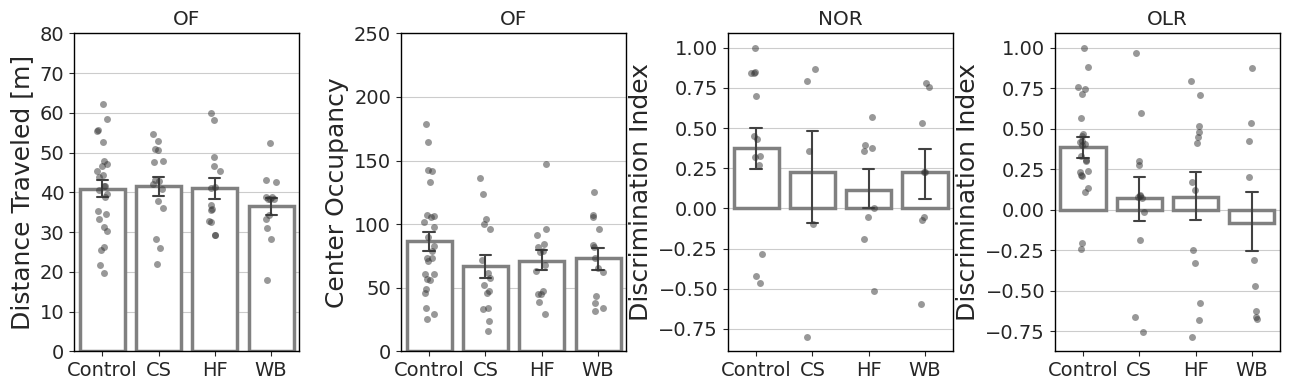

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway, kruskal
from scikit_posthocs import posthoc_dunn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, ax = plt.subplots(1, 4, figsize=(13, 4))
bTtx = TtxNames
bpalette = ttxpalette(bTtx)
hatches = [" ", "//"]

# Function to perform ANOVA and Tukey's HSD
def anova_tukey(df, var, treatments):
    print(f"Analyzing variable: {var}")

    # Drop NaNs for the given variable
    df_clean = df.dropna(subset=[var])

    # Kruskal-Wallis test (non-parametric)
    groups = [df_clean[df_clean['Treatment'] == treatment][var] for treatment in treatments]
    n_vals = [len(group) for group in groups]  # Report n values for each group

    # Kruskal-Wallis test
    h_stat, p_value = kruskal(*groups)
    df_kw = len(treatments) - 1  # Degrees of freedom

    if p_value < 0.05:
        bsign = 'yes'
    else:
        bsign = 'ns'

    print(f"Kruskal-Wallis H-statistic: {h_stat:.2f}, p-value: {p_value:.2e}, df={df_kw}, n={n_vals}, sign = {bsign}")

    # Dunn's Test with Bonferroni correction
    dunn_results = posthoc_dunn(df_clean, val_col=var, group_col='Treatment', p_adjust='bonferroni')
    print(f"Dunn's Test Results (Bonferroni adjusted, n={n_vals}):")
    print(dunn_results)

    return dunn_results

# Open Field - Distance Traveled
hax = ax[0]
var = 'Dist'
OF.dropna(subset=[var], inplace=True)
OF = OF[np.in1d(OF.Animal, OLR.Animal)].reset_index(drop=True)
sns.stripplot(data=OF, x='Treatment', y=var, ax=hax, order=bTtx, color='.2', edgecolor='k', alpha=0.5)
sns.barplot(data=OF, x='Treatment', y=var, ax=hax, order=bTtx, capsize=.2, errwidth=1.5, linewidth=2.5, edgecolor=".5", facecolor='w', ci=68)
hax.set_xlabel(None)
hax.set_ylabel('Distance Traveled [m]')
hax.set_title('OF')
hax.set_ylim([0, 80])
anova_tukey(OF, var, bTtx)

# Open Field - Center Occupancy
hax = ax[1]
var = 'Occ'
OF.dropna(subset=[var], inplace=True)
OF = OF[np.in1d(OF.Animal, OLR.Animal)].reset_index(drop=True)
sns.stripplot(data=OF, x='Treatment', y=var, ax=hax, order=bTtx, color='.2', edgecolor='k', alpha=0.5)
sns.barplot(data=OF, x='Treatment', y=var, ax=hax, order=bTtx, capsize=.2, errwidth=1.5, linewidth=2.5, edgecolor=".5", facecolor='w', ci=68)
hax.set_xlabel(None)
hax.set_ylabel('Center Occupancy')
hax.set_title('OF')
hax.set_ylim([0, 250])
anova_tukey(OF, var, bTtx)

# NOR - Discrimination Index
hax = ax[2]
var = 'DI'
Z = NOR
sns.stripplot(data=Z, x='Treatment', y=var, ax=hax, order=bTtx, color='.2', edgecolor='k', alpha=0.5, dodge=True)
sns.barplot(data=Z, x='Treatment', y=var, ax=hax, order=bTtx, capsize=.2, errwidth=1.5, linewidth=2.5, edgecolor=".5", ci=68, dodge=True, facecolor='w')
hax.set_xlabel(None)
hax.set_ylabel('Discrimination Index')
hax.set_title('NOR')
hax.ticklabel_format(axis='y', style='plain')
anova_tukey(Z, var, bTtx)

# OLR - Discrimination Index
hax = ax[3]
var = 'DI'
Z = OLR
sns.stripplot(data=Z, x='Treatment', y=var, ax=hax, order=bTtx, color='.2', edgecolor='k', alpha=0.5, dodge=True)
sns.barplot(data=Z, x='Treatment', y=var, ax=hax, order=bTtx, capsize=.2, errwidth=1.5, linewidth=2.5, edgecolor=".5", ci=68, dodge=True, facecolor='w')
hax.set_xlabel(None)
hax.set_ylabel('Discrimination Index')
hax.set_title('OLR')
hax.ticklabel_format(axis='y', style='plain')
anova_tukey(Z, var, bTtx)

# Save and show plot
fname = f'Beh_panel2.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches='tight', pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()


In [ ]:
#L= pd.read_csv(homeFolder + 'EvTable_Training.csv')
L= pd.read_excel(homeFolder + 'EvTable_Training2.xlsx')
L.Treatment[L.Treatment == 'PFC'] = 'CS'
L.Treatment[L.Treatment == 'HIPP'] = 'HF'
L.Treatment[L.Treatment == 'CTRL'] = 'Control'
L['Resp'] = L.Cue == L.Choice
L.head(10)

,Column1,Animal,Session,Treatment,Trial,Cue,Choice,hCue,hChoice,Duration,Resp,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,135.0,R100,1,CS,2,0,0,1,1,66.319567,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,136.0,R100,1,CS,3,1,1,0,0,82.459967,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,322.0,R100,2,CS,2,0,0,1,1,13.659233,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,323.0,R100,2,CS,3,1,1,0,0,110667.437967,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1934.0,R100,7,CS,2,0,0,1,1,54.000000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1935.0,R100,7,CS,3,1,0,0,0,123.000000,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1936.0,R100,7,CS,4,1,1,1,0,22.000000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1937.0,R100,7,CS,5,0,1,1,1,53.000000,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1938.0,R100,7,CS,6,0,1,0,1,76.000000,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2208.0,R100,8,CS,2,0,0,0,1,17.580000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sessions = np.unique(L.Session)
rats = np.unique(L.Animal)

bS = []
bPerf = []
bTtx = []
bRat = []
nTrials = []
for sx in sessions:
  for ix, rat in enumerate(rats):
    sel = (L.Animal == rat) & (L.Session == sx)

    if np.sum(sel) == 0:
      continue

    nTrials.append(np.sum(sel))
    ttx = np.unique(L.Treatment[sel])[0]

    bS.append(sx)
    if ttx == 'Control':
      val = (np.sum(L.Resp[sel] == True)/np.sum(sel))
    else:
      val = (np.sum(L.Resp[sel] == True)/np.sum(sel))

    if (val > 0.5) & (np.sum(sel) < 5):
      val = np.nan

    bPerf.append(val)
    bTtx.append(ttx)
    bRat.append(rat)

dfb = pd.DataFrame({'Session': bS, 'Animal': bRat, 'Treatment': bTtx, 'Performance': bPerf, 'nTrials': nTrials})
dfb.head()


,Session,Animal,Treatment,Performance,nTrials
0,1,R100,CS,NaN,2
1,1,R101,CS,NaN,2
2,1,R102,WB,0.600000,5
3,1,R103,Control,0.500000,4
4,1,R104,HF,0.333333,6


In [ ]:
path = homeFolder + 'FractalTable2.csv'
L= pd.read_csv(path)
L.head(3)

,Rec,Hemi,Trial,Structure,Band,Epoch,Cue,Outcome,Power,Freq,Acc,Treatment,Rat
0,Rec1,L,1,NAcCore,Theta,Start,RIGHT,HIT,16.184176,5.615234,0.084503,Control,R76
1,Rec1,L,1,NAcCore,Beta,Start,RIGHT,HIT,10.220291,27.832031,0.084503,Control,R76
2,Rec1,L,1,NAcCore,Gamma,Start,RIGHT,HIT,5.958363,55.664062,0.084503,Control,R76


In [ ]:
np.unique(L.Rat)

array(['FD', 'R105', 'R118', 'R123', 'R128', 'R136', 'R76', 'R92', 'R94'],
      dtype=object)

In [ ]:
np.unique(dfb.Animal)

array(['R100', 'R101', 'R102', 'R103', 'R104', 'R105', 'R106', 'R107',
       'R108', 'R116', 'R117', 'R118', 'R119', 'R120', 'R121', 'R122',
       'R123', 'R124', 'R125', 'R126', 'R127', 'R128', 'R23', 'R34',
       'R61', 'R62', 'R63', 'R64', 'R75', 'R76', 'R89', 'R90', 'R91',
       'R92', 'R93', 'R94', 'R96', 'R98', 'R99'], dtype=object)

                    sum_sq    df         F    PR(>F)
C(Ttx)            0.028447   1.0  1.714209  0.210142
C(Period)         0.009884   1.0  0.595593  0.452252
C(Ttx):C(Period)  0.003644   1.0  0.219568  0.646106
Residual          0.248921  15.0       NaN       NaN
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
  CTRL:End CTRL:Start   0.0196 0.9949 -0.2153 0.2544  False
  CTRL:End     WB:End  -0.1071 0.6129 -0.3561  0.142  False
  CTRL:End   WB:Start  -0.0319 0.9789 -0.2667  0.203  False
CTRL:Start     WB:End  -0.1266  0.481 -0.3757 0.1224  False
CTRL:Start   WB:Start  -0.0514 0.9204 -0.2862 0.1834  False
    WB:End   WB:Start   0.0752 0.8199 -0.1738 0.3243  False
-----------------------------------------------------------


                    sum_sq    df         F    PR(>F)
C(Ttx)            0.000026   1.0  0.001128  0.973536
C(Period)         0.090951 

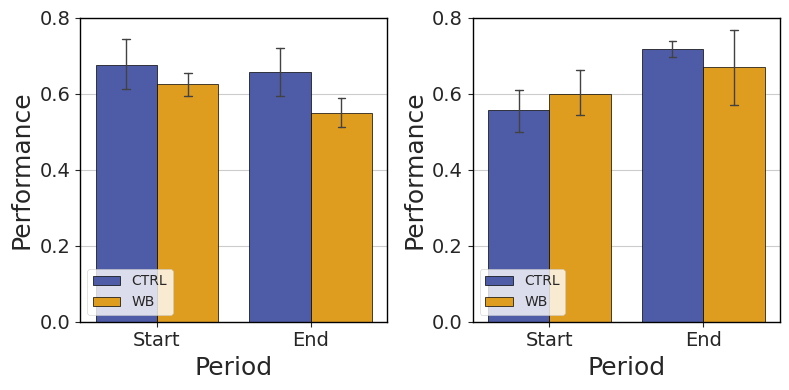

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


def run2WA(df, val, factor1, factor2):
  df.dropna(subset = val, inplace = True)
  # Fit the model
  model = ols(f'{val} ~ C({factor1}) + C({factor2}) + C({factor1})*C({factor2})', data=df).fit()

  # Perform two-way ANOVA
  anova_table = sm.stats.anova_lm(model, typ=2)
  print(anova_table)

  # Tukey's HSD Test
  tukey_results = pairwise_tukeyhsd(df[val], df[factor1] + ":" + df[factor2])
  print(tukey_results)


path = homeFolder + 'Table_Learners1.csv'
dummy = pd.read_csv(path)

# Create new DataFrame for merging
data = {'Performance': pd.concat([dummy['pStart'], dummy['pEnd']]),
        'Period': ['Start'] * len(dummy) + ['End'] * len(dummy),
        'Learner': dummy['learner'].tolist() * 2,
        'Ttx': dummy['tVar'].tolist() * 2,
        'Rat': dummy['rVar'].tolist() * 2
       }

L = pd.DataFrame(data)
L = L[np.in1d(L.Ttx, ['CTRL', 'WB'])]
L = L.reset_index(drop=True)  # Drop the old index column

fig, ax = plt.subplots(1,2, figsize = (8,4))
hax = ax[0]
sns.barplot(data = L[L.Learner == 0], x = 'Period', y = 'Performance', hue = 'Ttx', ci = 68, ax = hax, capsize = 0.1, errwidth=1, edgecolor = 'k')
hax.set_ylim([0, 0.8])
hax.legend(loc = 'lower left', title = None)
run2WA(L[L.Learner == 0], 'Performance', 'Ttx', 'Period')
print('\n')

hax = ax[1]
sns.barplot(data = L[L.Learner == 1], x = 'Period', y = 'Performance', hue = 'Ttx', ci = 68, ax = hax, capsize = 0.1, errwidth=1, edgecolor = 'k')
hax.set_ylim([0, 0.8])
hax.legend(loc = 'lower left', title = None)
run2WA(L[L.Learner == 1], 'Performance', 'Ttx', 'Period')

plt.tight_layout()

In [ ]:
lC = len(L[(L.Ttx == 'CTRL') & (L.Learner == 1) & (L.Period == 'Start')]);
lWB = len(L[(L.Ttx == 'WB') & (L.Learner == 1) & (L.Period == 'Start')]);
print(f'Control Learners: {lC} - WB Learners: {lWB}')


nlC = len(L[(L.Ttx == 'CTRL') & (L.Learner == 0) & (L.Period == 'Start')]);
nlWB = len(L[(L.Ttx == 'WB') & (L.Learner == 0) & (L.Period == 'Start')]);
print(f'Control Non-Learners: {nlC} - WB Non-Learners: {nlWB}')


Control Learners: 7 - WB Learners: 5
Control Non-Learners: 5 - WB Non-Learners: 5


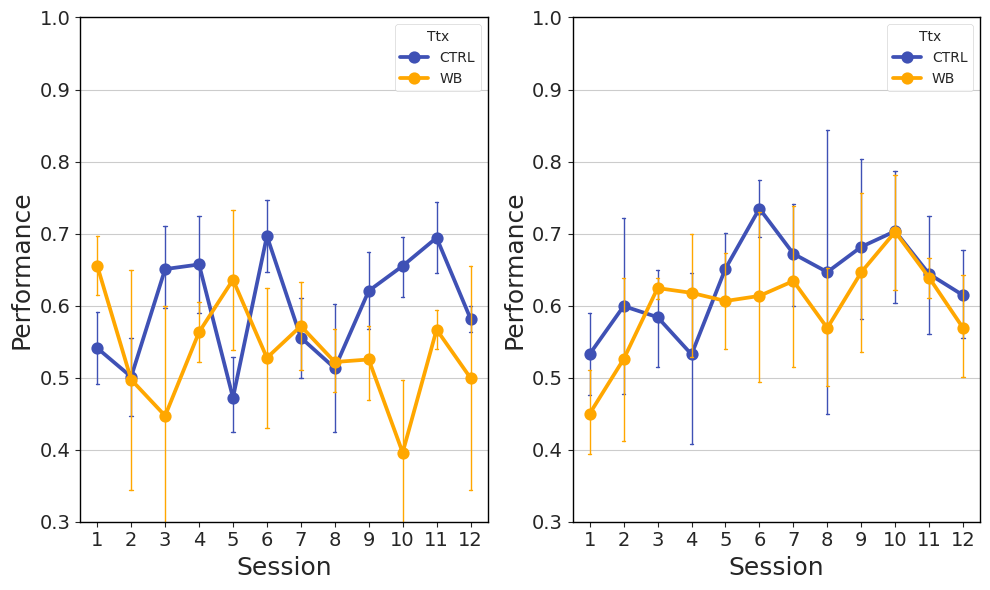

In [ ]:
path = homeFolder + 'Table_TMAZE_sessions.xlsx'
dummy = pd.read_excel(path)
dummy = dummy[(np.in1d(dummy.Ttx, ['CTRL', 'WB'])) & (dummy.Performance<1) & (dummy.nTrials>2) & (dummy.Session <= 12)]
dummy = dummy.reset_index(drop=True)  # Drop the old index column

fig, ax = plt.subplots(1,2, figsize = (10,6))
hax = ax[0]
sns.pointplot(ax = hax, data = dummy[np.in1d(dummy.Rat, L.Rat[L.Learner == 0])], x = 'Session', y = 'Performance', hue = 'Ttx', ci = 68, capsize = 0.1, errwidth=1)

hax.set_ylim([0.3,1])
hax = ax[1]
sns.pointplot(ax = hax, data = dummy[np.in1d(dummy.Rat, L.Rat[L.Learner == 1])], x = 'Session', y = 'Performance', hue = 'Ttx', ci = 68, capsize = 0.1, errwidth=1)
hax.set_ylim([0.3,1])

plt.tight_layout()
plt.show()



In [ ]:
np.unique(dummy.Rat)

array(['R102', 'R103', 'R105', 'R106', 'R107', 'R108', 'R116', 'R117',
       'R118', 'R120', 'R122', 'R123', 'R125', 'R126', 'R128', 'R23',
       'R63', 'R64', 'R75', 'R76', 'R89', 'R92', 'R99'], dtype=object)

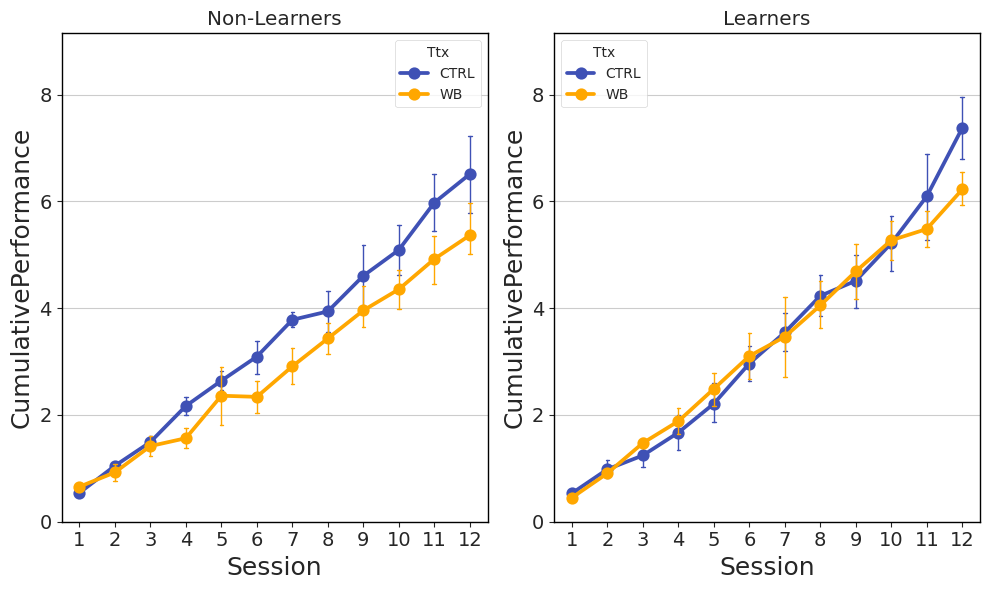

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = homeFolder + 'Table_TMAZE_sessions.xlsx'
dummy = pd.read_excel(path)
dummy = dummy[(np.in1d(dummy.Ttx, ['CTRL', 'WB'])) & (dummy.Performance<1) & (dummy.nTrials>2) & (dummy.Session <= 12)]
dummy = dummy.reset_index(drop=True)

# Calculate cumulative performance per rat (crucial change!)
dummy["CumulativePerformance"] = dummy.groupby(["Rat", "Ttx"])["Performance"].cumsum()

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Plot cumulative performance for non-learners
hax = ax[0]
sns.pointplot(ax=hax, data=dummy[np.in1d(dummy.Rat, L.Rat[L.Learner == 0])],
              x='Session', y='CumulativePerformance', hue='Ttx', ci=68, capsize=0.1, errwidth=1)
hax.set_ylim([0, dummy.groupby("Rat")["CumulativePerformance"].max().max() + 1]) # Adjust based on max per rat
hax.set_title("Non-Learners")

# Plot cumulative performance for learners
hax = ax[1]
sns.pointplot(ax=hax, data=dummy[np.in1d(dummy.Rat, L.Rat[L.Learner == 1])],
              x='Session', y='CumulativePerformance', hue='Ttx', ci=68, capsize=0.1, errwidth=1)
hax.set_ylim([0, dummy.groupby("Rat")["CumulativePerformance"].max().max() + 1]) # Adjust based on max per rat
hax.set_title("Learners")

plt.tight_layout()
plt.show()


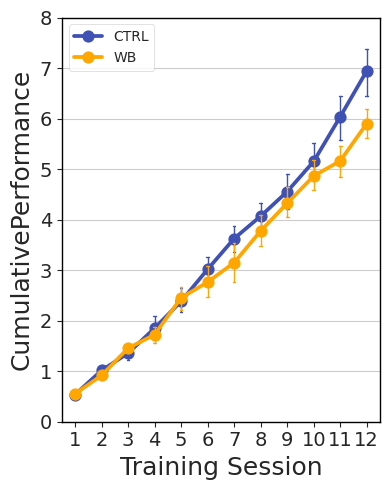

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 5))

# Plot cumulative performance for non-learners
hax = ax
sns.pointplot(ax=hax, data=dummy, x='Session', y='CumulativePerformance', hue='Ttx', ci=68, capsize=0.1, errwidth=1)
hax.set_ylim([0, 8]) # Adjust based on max per rat
hax.legend(loc = 'upper left')
hax.set_xlabel('Training Session')
fname = f'CumulativePerf_All.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches='tight', pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()


In [ ]:
a

,Value
Observed Statistic,1.459274
Bootstrap P-Value,0.0092
Confidence Interval,"[-1.1045068247518932, 1.14499359166747]"
Test Type,Mann-Whitney U test
Test Statistic,15.0
Degrees of Freedom,None
Parametric P-Value,0.035714
Sample Size Group 1 (N1),3
Sample Size Group 2 (N2),5
Group 1 Central Tendency,Mean: 5.1940 ± SE: 0.2673


In [ ]:
import scipy.stats as stats

bdata = dummy
#bdata = dummy[np.in1d(dummy.Rat, L.Rat[L.Learner == 1])]
for sess in [1,2,3,4,5,6,7,8,9,10,11,12]:
  #differences = bdata.CumulativePerformance[(bdata.Session == sess) & (bdata.Ttx == 'CTRL')] - 0.5

  # Perform the Wilcoxon signed-rank test
  #statistic, p_value = wilcoxon(differences)

  d1 = dummy.CumulativePerformance[(dummy.Ttx == 'CTRL') & (dummy.Session == sess)]
  d2 = dummy.CumulativePerformance[(dummy.Ttx == 'WB') & (dummy.Session == sess)]

  #t_statistic, p_value = stats.mannwhitneyu(d1,d2, nan_policy='omit')
  a = bootstrap_test(d1, d2)


  print(f"Session {sess} - p_value: {a['Value'][1]} - N CTRL-WB [{a.Value[7]}, {a.Value[8]}]")

Session 1 - p_value: 0.7659 - N CTRL-WB [10, 10]
Session 2 - p_value: 0.4279 - N CTRL-WB [6, 6]
Session 3 - p_value: 0.6062 - N CTRL-WB [11, 6]
Session 4 - p_value: 0.6325 - N CTRL-WB [11, 10]
Session 5 - p_value: 0.8428 - N CTRL-WB [10, 7]
Session 6 - p_value: 0.5085 - N CTRL-WB [12, 9]
Session 7 - p_value: 0.2912 - N CTRL-WB [9, 7]
Session 8 - p_value: 0.4561 - N CTRL-WB [9, 9]
Session 9 - p_value: 0.6284 - N CTRL-WB [9, 8]
Session 10 - p_value: 0.5424 - N CTRL-WB [10, 9]
Session 11 - p_value: 0.136 - N CTRL-WB [8, 7]
Session 12 - p_value: 0.0838 - N CTRL-WB [6, 8]


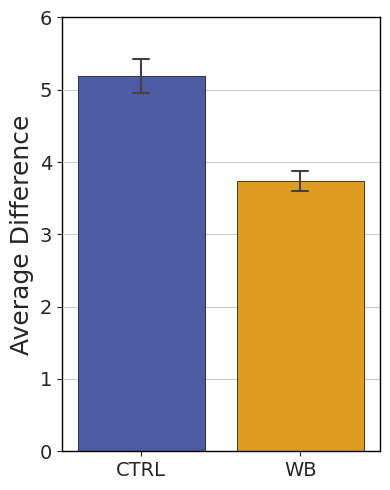

                                                            Value
Observed Statistic                                       1.459274
Bootstrap P-Value                                          0.0092
Confidence Interval       [-1.1045068247518932, 1.14499359166747]
Test Type                                     Mann-Whitney U test
Test Statistic                                               15.0
Degrees of Freedom                                           None
Parametric P-Value                                       0.035714
Sample Size Group 1 (N1)                                        3
Sample Size Group 2 (N2)                                        5
Group 1 Central Tendency                Mean: 5.1940 ± SE: 0.2673
Group 2 Central Tendency                Mean: 3.7348 ± SE: 0.1657


In [ ]:
#collect performance per Rat:
a = []
#for rat in np.unique(dummy.Rat):
for rat in np.unique(dummy.Rat[np.in1d(dummy.Rat, L.Rat[L.Learner == 1])]):
  a.append((np.nanmean(dummy.CumulativePerformance[(dummy.Session == 5) & (dummy.Rat == rat)]),
            np.nanmean(dummy.CumulativePerformance[(dummy.Session == 12) & (dummy.Rat == rat)]),
            np.unique(dummy.Ttx[dummy.Rat == rat])[0]))

asdf = pd.DataFrame(data = a, columns = ['First', 'Second', 'Ttx'])
asdf.dropna(subset = ['First', 'Second'], inplace = True)
# Calculate the difference between Second and First for each treatment
asdf["Diff"] = asdf["Second"] - asdf["First"]

# Plotting with Seaborn (preferred for cleaner aesthetics)
fig, ax = plt.subplots(1,1, figsize=(4, 5))
sns.barplot(data=asdf, x="Ttx", y="Diff", capsize=0.1, ci = 68, order = ['CTRL', 'WB'], palette = ttxpalette(['CTRL', 'WB']), edgecolor = 'k', errwidth = 1.5)
#sns.stripplot(data=asdf, x="Ttx", y="Diff", order = ['CTRL', 'WB'])
#plt.title("Difference Between Second and First Values (CTRL vs. WB)")
plt.xlabel(None)
plt.ylabel("Average Difference")
ax.set_ylim([0, 6])

fname = f'AvgDiff_Learners.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches='tight', pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()

a = bootstrap_test(asdf.Diff[asdf.Ttx == 'CTRL'],asdf.Diff[asdf.Ttx == 'WB'])

print(a)





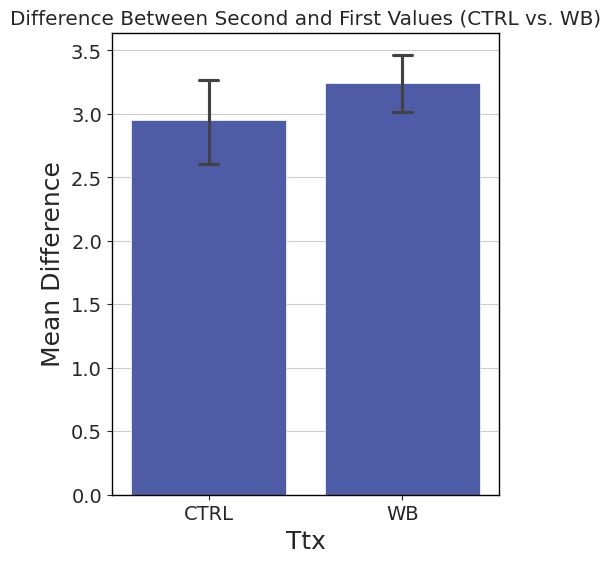

                                                              Value
Observed Statistic                                        -0.289879
Bootstrap P-Value                                            0.5092
Confidence Interval       [-0.8437217588773126, 0.8424783707872917]
Test Type                                       Mann-Whitney U test
Test Statistic                                                 15.0
Degrees of Freedom                                             None
Parametric P-Value                                         0.755051
Sample Size Group 1 (N1)                                          7
Sample Size Group 2 (N2)                                          5
Group 1 Central Tendency                  Mean: 2.9501 ± SE: 0.3513
Group 2 Central Tendency                  Mean: 3.2400 ± SE: 0.2317


In [ ]:
#collect performance per Rat:
var = 'CumulativePerformance'
a = []
for rat in np.unique(dummy.Rat[np.in1d(dummy.Rat, L.Rat[L.Learner == 1])]):
  a.append((np.nanmean(dummy[var][(dummy.Session <= 5) & (dummy.Rat == rat)]),
            np.nanmean(dummy[var][(dummy.Session >= 6) & (dummy.Session <= 12) & (dummy.Rat == rat)]),
            np.unique(dummy.Ttx[dummy.Rat == rat])[0]))

asdf = pd.DataFrame(data = a, columns = ['First', 'Second', 'Ttx'])

# Calculate the difference between Second and First for each treatment
asdf["Diff"] = asdf["Second"] - asdf["First"]

# Plotting with Seaborn (preferred for cleaner aesthetics)
plt.figure(figsize=(5, 6))
sns.barplot(data=asdf, x="Ttx", y="Diff", capsize=0.1, ci = 68, order = ['CTRL', 'WB'])
#sns.stripplot(data=asdf, x="Ttx", y="Diff")
plt.title("Difference Between Second and First Values (CTRL vs. WB)")
plt.ylabel("Mean Difference")

plt.show()

a = bootstrap_test(asdf.Diff[asdf.Ttx == 'CTRL'],asdf.Diff[asdf.Ttx == 'WB'])

print(a)





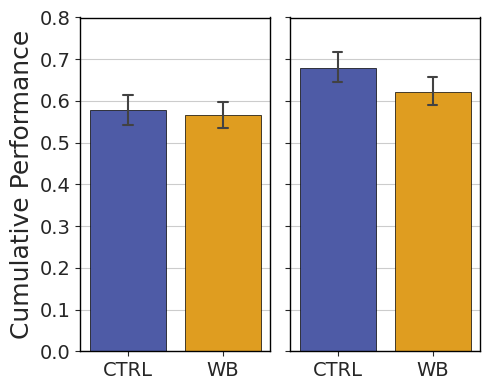

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (5,4), sharey = True)

hax = ax[0]
sns.barplot(data = dummy[(dummy.Session <= 5) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])], x = 'Ttx', y = 'Performance', ax = hax,
            capsize=0.1, ci = 68, palette = ttxpalette(['CTRL', 'WB']), errwidth = 1.5, edgecolor = 'k')
hax.set_ylabel('Cumulative Performance')
hax.set_xlabel(None)
hax.set_ylim([0, 0.8])
hax = ax[1]
sns.barplot(data = dummy[(dummy.Session >= 6) & (dummy.Session <= 12) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])], x = 'Ttx', y = 'Performance', ax = hax,
            capsize=0.1, ci = 68, palette = ttxpalette(['CTRL', 'WB']), errwidth = 1.5, edgecolor = 'k')
hax.set_xlabel(None)
hax.set_ylim([0, 0.8])

fname = f'CumulativePerf_LearnersWeeks.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches='tight', pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()


In [ ]:
a = bootstrap_test(dummy.CumulativePerformance[(dummy.Ttx == 'CTRL') & (dummy.Session == 5) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])],
                   dummy.CumulativePerformance[(dummy.Ttx == 'WB') & (dummy.Session == 5) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])])
print(f'Session 5: \n{a}')

a = bootstrap_test(dummy.CumulativePerformance[(dummy.Ttx == 'CTRL') & (dummy.Session == 12) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])],
                   dummy.CumulativePerformance[(dummy.Ttx == 'WB') & (dummy.Session == 12) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])])
print(f'Session 12: \n{a}')


Session 5: 
                                                              Value
Observed Statistic                                        -0.278078
Bootstrap P-Value                                            0.5807
Confidence Interval       [-0.9638580562955559, 0.9904473917286416]
Test Type                                       Mann-Whitney U test
Test Statistic                                                 14.0
Degrees of Freedom                                             None
Parametric P-Value                                         0.930736
Sample Size Group 1 (N1)                                          6
Sample Size Group 2 (N2)                                          5
Group 1 Central Tendency                  Mean: 2.2112 ± SE: 0.4080
Group 2 Central Tendency                  Mean: 2.4893 ± SE: 0.3252
Session 12: 
                                                             Value
Observed Statistic                                        1.150869
Bootstrap P-Value        

[0.5777955664121242, 0.56574296915206]
[0.6795811451606142, 0.6224609571540519]


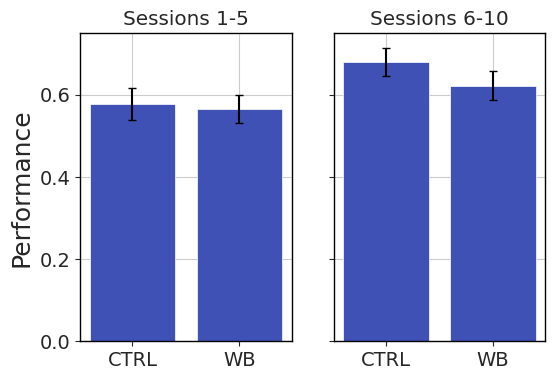

In [ ]:
a1 = dummy.Performance[(dummy.Ttx == 'CTRL') & (dummy.Session <= 5) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])]
b1 = dummy.Performance[(dummy.Ttx == 'WB') & (dummy.Session <= 5) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])]

p = [np.nanmean(a1), np.nanmean(b1)]

sp = [np.nanstd(a1)/np.sqrt(len(a1)), np.nanstd(b1)/np.sqrt(len(b1))]

a2 = dummy.Performance[(dummy.Ttx == 'CTRL') & (dummy.Session >= 6)  & (dummy.Session <= 12) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])]
b2 = dummy.Performance[(dummy.Ttx == 'WB') & (dummy.Session >= 6)  & (dummy.Session <= 12) & np.in1d(dummy.Rat, L.Rat[L.Learner == 1])]

q = [np.nanmean(a2), np.nanmean(b2)]

sq = [np.nanstd(a2)/np.sqrt(len(a2)), np.nanstd(b2)/np.sqrt(len(b2))]

a = q[0] - p[0]
b = q[1] - p[1]

print(p)
print(q)

fig, ax = plt.subplots(1,2,figsize = (6,4), sharey = True)
hax = ax[0]
hax.bar(['CTRL', 'WB'], p)
hax.errorbar(['CTRL', 'WB'], p, sp, ecolor='k', linestyle='', capsize= 3)
hax.set_ylabel('Performance')
hax.set_title('Sessions 1-5')

hax = ax[1]
hax.bar(['CTRL', 'WB'], q)
hax.errorbar(['CTRL', 'WB'], q, sq, ecolor='k', linestyle='', capsize= 3)
#hax.set_ylabel('Performance')
hax.set_title('Sessions 6-10')

plt.show()


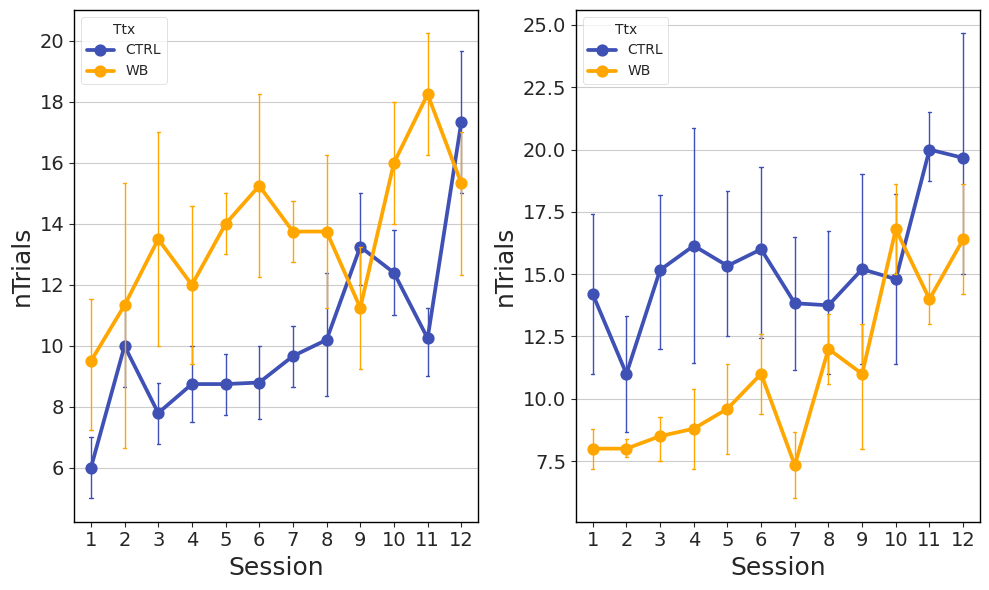

In [ ]:
path = homeFolder + 'Table_TMAZE_sessions.xlsx'
dummy = pd.read_excel(path)
dummy = dummy[(np.in1d(dummy.Ttx, ['CTRL', 'WB'])) & (dummy.Performance<1) & (dummy.nTrials>2) & (dummy.Session <= 12)]
dummy = dummy.reset_index(drop=True)  # Drop the old index column

fig, ax = plt.subplots(1,2, figsize = (10,6))
hax = ax[0]
sns.pointplot(ax = hax, data = dummy[np.in1d(dummy.Rat, L.Rat[L.Learner == 0])], x = 'Session', y = 'nTrials', hue = 'Ttx', ci = 68, capsize = 0.1, errwidth=1)
#hax.set_ylim([0.3,1])
hax = ax[1]
sns.pointplot(ax = hax, data = dummy[np.in1d(dummy.Rat, L.Rat[L.Learner == 1])], x = 'Session', y = 'nTrials', hue = 'Ttx', ci = 68, capsize = 0.1, errwidth=1)
# hax.set_ylim([0.3,1])

plt.tight_layout()
plt.show()



Control wk1 vs wk2: 
                                                                Value
Observed Statistic                                          -0.108948
Bootstrap P-Value                                              0.0583
Confidence Interval       [-0.11336779551811012, 0.11156690924207383]
Test Type                                         Mann-Whitney U test
Test Statistic                                                   22.0
Degrees of Freedom                                               None
Parametric P-Value                                           0.037635
Sample Size Group 1 (N1)                                           10
Sample Size Group 2 (N2)                                           10
Group 1 Central Tendency                    Mean: 0.5829 ± SE: 0.0422
Group 2 Central Tendency                    Mean: 0.6918 ± SE: 0.0357

WB wk1 vs wk2: 
                                              Value
Observed Statistic                        -0.021291
Bootstrap P-Value 

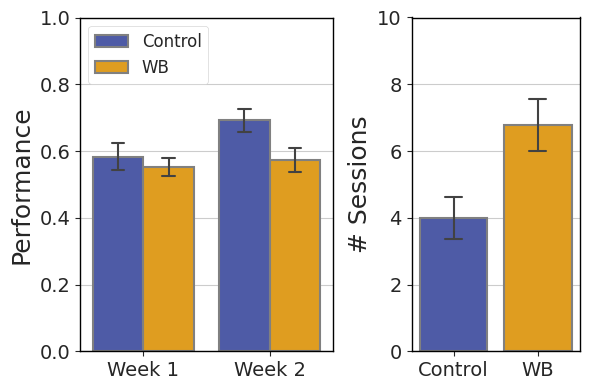

In [ ]:
#Performance per Week:
collect = []
#dummy = dfb[(dfb.Session <= 10) & np.in1d(dfb.Treatment, ['Control', 'WB']) & ~np.in1d(dfb.Animal, discard)]
dummy = dfb[(dfb.Session <= 10) & np.in1d(dfb.Treatment, ['Control', 'WB'])]

for rat in np.unique(dummy.Animal):
  ttx = np.unique(dummy.Treatment[(dummy.Animal == rat)])[0]
  bperf1 = np.array(dummy.Performance[(dummy.Animal == rat) & (dummy.Session < 5)])
  bperf2 = np.array(dummy.Performance[(dummy.Animal == rat) & (dummy.Session >= 5) & (dummy.Session <= 8)])

  collect.append((ttx, np.nanmean(bperf1), 'Week 1'))
  collect.append((ttx, np.nanmean(bperf2), 'Week 2'))

wdf = pd.DataFrame(data = collect, columns = ['Treatment', 'Performance', 'Week'])

fig, ax = plt.subplots(1,2,figsize = (6,4), width_ratios = [3,2])
hax = ax[0]
sns.barplot(data = wdf[(wdf.Treatment == 'Control') | (wdf.Treatment == 'WB')],
            x = 'Week', y = 'Performance', hue = 'Treatment', hue_order= ['Control', 'WB'],
            ci =68, dodge = True, palette = ttxpalette(['Control', 'WB']),
            capsize=.2, errwidth = 1.5, linewidth=1.5, edgecolor=".5", ax = hax)

hax.set_ylim([0,1])
hax.set_ylabel('Performance')
hax.set_xlabel(None)
hax.legend(title = None, fontsize = 12, loc = 'upper left')

t_statistic, p_value = mannwhitneyu(wdf.Performance[(wdf.Treatment == 'Control') & (wdf.Week == 'Week 1')],
                                          wdf.Performance[(wdf.Treatment == 'Control') & (wdf.Week == 'Week 2')] , nan_policy='omit')
a = bootstrap_test(wdf.Performance[(wdf.Treatment == 'Control') & (wdf.Week == 'Week 1')],
                                          wdf.Performance[(wdf.Treatment == 'Control') & (wdf.Week == 'Week 2')] )
print(f'Control wk1 vs wk2: \n{a}\n')

t_statistic, p_value = mannwhitneyu(wdf.Performance[(wdf.Treatment == 'WB') & (wdf.Week == 'Week 1')],
                                          wdf.Performance[(wdf.Treatment == 'WB') & (wdf.Week == 'Week 2')] , nan_policy='omit')
a = bootstrap_test(wdf.Performance[(wdf.Treatment == 'WB') & (wdf.Week == 'Week 1')],
                                          wdf.Performance[(wdf.Treatment == 'WB') & (wdf.Week == 'Week 2')] )
print(f'WB wk1 vs wk2: \n{a}\n')


over_thr = dfb[(dfb.Session <= 10) & np.in1d(dfb.Treatment, ['Control', 'WB'])]
over_thr = over_thr[over_thr.Performance >= 0.6]

#Number of sessions:
hax = ax[1]
collect = []
for rat in np.unique(over_thr.Animal):
  sel = over_thr.Animal == rat
  ttx = np.unique(over_thr.Treatment[sel])[0]
  bsess = np.array(over_thr.Session[sel])
  bperf = np.array(over_thr.Performance[sel])
  btrials = np.array(over_thr.nTrials[sel])

  n = 2
  if len(bsess) < n:
    continue

  collect.append((ttx, bsess[n-1], bperf[n-1], btrials[n-1]))

asdf = pd.DataFrame(data = collect, columns = ['Treatment', 'Session', 'Performance', 'nTrials'])

sns.barplot(data = asdf, x = 'Treatment', y = 'Session', ci = 68, order = ['Control', 'WB'], palette = ttxpalette(['Control', 'WB']),
            capsize=.2, errwidth = 1.5, linewidth=1.5, edgecolor=".5", ax = hax)
hax.set_ylabel('# Sessions')
hax.set_xlabel(None)
hax.set_ylim([0, 10])

#t_statistic, p_value = mannwhitneyu(asdf.Session[asdf.Treatment == 'Control'], asdf.Session[asdf.Treatment == 'WB'], nan_policy='omit')
#print(f'Number of sessions per Week: {p_value:.4f}')
a = bootstrap_test(asdf.Session[asdf.Treatment == 'Control'], asdf.Session[asdf.Treatment == 'WB'])
print(a)

fname = f'PerfWeek.png'
plt.tight_layout()
#plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches='tight', pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()

In [ ]:
len(np.unique(dfb.Animal[np.in1d(dfb.Treatment, ['Control', 'WB'])]))

21

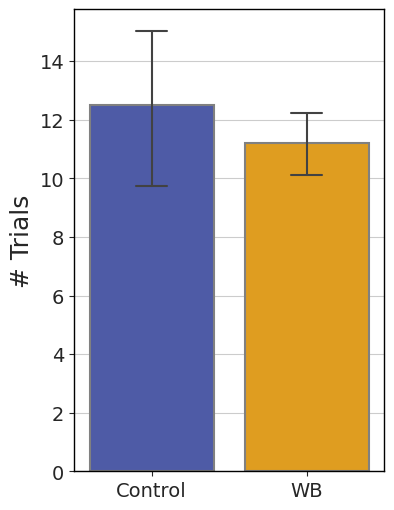

In [ ]:
fig,hax = plt.subplots(1,1,figsize=(4,6))
sns.barplot(data = asdf, x = 'Treatment', y = 'nTrials', ci = 68, order = ['Control', 'WB'], palette = ttxpalette(['Control', 'WB']),
            capsize=.2, errwidth = 1.5, linewidth=1.5, edgecolor=".5", ax = hax)
hax.set_ylabel('# Trials')
hax.set_xlabel(None)
plt.show()